In [1]:
import zipfile as zp
import pandas as pd
import numpy as np
# from pypac import PACSession as Session #or use requests below if non-ONS
#from requests import Session
from io import BytesIO
import os
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import LoadData as dataLoader
%matplotlib notebook

###  Read in files


In [ ]:
# Path to zip files
path = "/Users/lb8075/Loneliness_Data_challenge/Loneliness_notebook/Data/"

In [ ]:
print (path[:-5])
print (path[:-25])

First lets load all the data... do this just once!

In [2]:
proc_data, proc_data_dict =dataLoader.loadFinalData('../Loneliness')
codes=dataLoader.loadProccessedData('../Loneliness')
drugs_list = dataLoader.loadDrugsList('../Loneliness')
msoa_data, msoa_data_dict = dataLoader.loadmsoaData('../Loneliness')

In [3]:
merged_data = dataLoader.mergeDataSources(proc_data,codes)
merged_data.head(10)

,pcstrip,Year,NUMBER_OF_PATIENTS,SHA,PCT,oseast1m,osnrth1m,lsoa11,msoa11,ru11ind,...,alzheimers,Street,hypertension,cardiovascular disease,Date,addiction,Town2,CenterName,depression,diabetes
0,AL100BS,2016,3171.916667,Q58,06K,522443,208996,E01023927,E02004990,C1,...,41,9/11 WELLFIELD ROAD,1014,1008,201810,0,HERTFORDSHIRE,WRAFTON HOUSE SURGERY,998,353
1,AL100BS,2016,3171.916667,Q58,06K,522443,208996,E01023927,E02004990,C1,...,39,9/11 WELLFIELD ROAD,947,982,201811,0,HERTFORDSHIRE,WRAFTON HOUSE SURGERY,922,334
2,AL100BS,2016,3171.916667,Q58,06K,522443,208996,E01023927,E02004990,C1,...,41,9/11 WELLFIELD ROAD,969,924,201812,0,HERTFORDSHIRE,WRAFTON HOUSE SURGERY,876,325
3,AL100BS,2017,7990.750000,Q58,06K,522443,208996,E01023927,E02004990,C1,...,41,9/11 WELLFIELD ROAD,1014,1008,201810,0,HERTFORDSHIRE,WRAFTON HOUSE SURGERY,998,353
4,AL100BS,2017,7990.750000,Q58,06K,522443,208996,E01023927,E02004990,C1,...,39,9/11 WELLFIELD ROAD,947,982,201811,0,HERTFORDSHIRE,WRAFTON HOUSE SURGERY,922,334
5,AL100BS,2017,7990.750000,Q58,06K,522443,208996,E01023927,E02004990,C1,...,41,9/11 WELLFIELD ROAD,969,924,201812,0,HERTFORDSHIRE,WRAFTON HOUSE SURGERY,876,325
6,AL100BS,2018,9624.416667,Q58,06K,522443,208996,E01023927,E02004990,C1,...,41,9/11 WELLFIELD ROAD,1014,1008,201810,0,HERTFORDSHIRE,WRAFTON HOUSE SURGERY,998,353
7,AL100BS,2018,9624.416667,Q58,06K,522443,208996,E01023927,E02004990,C1,...,39,9/11 WELLFIELD ROAD,947,982,201811,0,HERTFORDSHIRE,WRAFTON HOUSE SURGERY,922,334
8,AL100BS,2018,9624.416667,Q58,06K,522443,208996,E01023927,E02004990,C1,...,41,9/11 WELLFIELD ROAD,969,924,201812,0,HERTFORDSHIRE,WRAFTON HOUSE SURGERY,876,325
9,AL100NL,2016,4195.000000,Q58,06K,522442,208808,E01023920,E02004991,C1,...,58,THE COMMON,1503,1419,201810,0,HERTFORDSHIRE,LISTER HOUSE,1394,443


In [4]:
mergedData= proc_data.merge( codes , on=['PCT','pcstrip','SHA'])
mergedData.reset_index(drop=False, inplace=True)
mergedData.columns

Index(['index', 'pcstrip', 'Year', 'NUMBER_OF_PATIENTS', 'SHA', 'PCT',
       'oseast1m', 'osnrth1m', 'lsoa11', 'msoa11', 'ru11ind', 'rgn', 'laua',
       'imd', 'depression_perc', 'alzheimers_perc', 'blood pressure_perc',
       'hypertension_perc', 'diabetes_perc', 'cardiovascular disease_perc',
       'insomnia_perc', 'addiction_perc', 'social anxiety_perc',
       'loneliness_perc', 'depression_zscore', 'alzheimers_zscore',
       'blood pressure_zscore', 'hypertension_zscore', 'diabetes_zscore',
       'cardiovascular disease_zscore', 'insomnia_zscore', 'addiction_zscore',
       'social anxiety_zscore', 'loneliness_zscore', 'loneills', 'PracCode',
       'Town', 'Postcode', 'blood pressure', 'ITEMS', 'loneliness',
       'social anxiety', 'insomnia', 'alzheimers', 'Street', 'hypertension',
       'cardiovascular disease', 'Date', 'addiction', 'Town2', 'CenterName',
       'depression', 'diabetes'],
      dtype='object')

In [ ]:
def getLonelinessScore(x) : 
    return pd.DataFrame(dict(Loneliness=list(x['loneliness_zscore'].unique())))

df = mergedData.groupby(['PCT','pcstrip','SHA','Postcode','Date'])#.apply(getLonelinessScore)
#df.reset_index(drop=False, inplace=True)
#df = df[['PCT','pcstrip','Postcode','Date','Loneliness']]
#df.head(10)

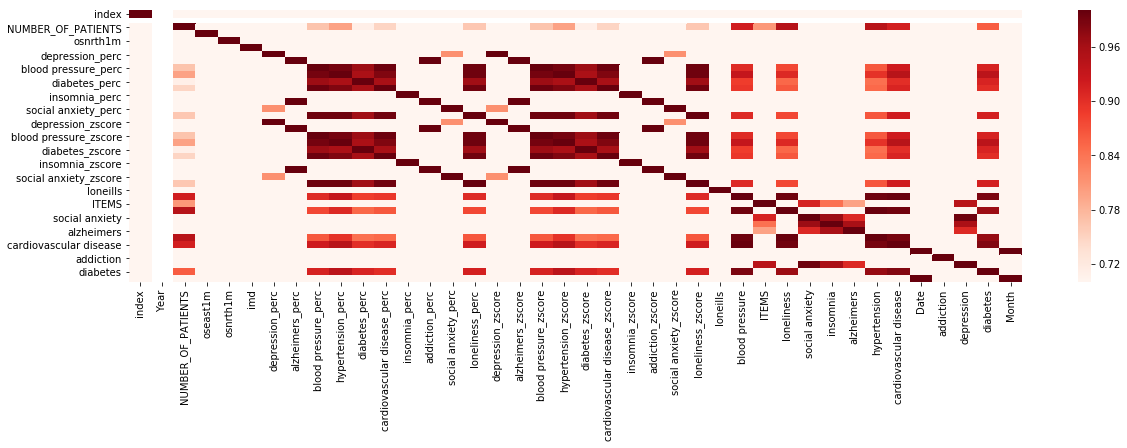

In [10]:
import seaborn as sns

# super simple check of whats correlated with what
mergedData['Year'] = np.floor(mergedData['Date']/100).astype(int)
mergedData['Month'] = mergedData['Date'] - 100*mergedData['Year']
mergedData[['Year','Month','Date']].head(10)
agg = mergedData.groupby(['PCT','pcstrip','SHA','Postcode']).aggregate(np.mean)
# now lets see ones that are 3 sigma away from the mean 
meanScore = agg['loneliness_zscore'].mean()
stdScore = agg['loneliness_zscore'].std()
df = agg.loc[ np.abs(agg['loneliness_zscore'] -meanScore) > 5*stdScore ]
plt.figure(figsize=(20,5))
correlations = df.corr()
sns.heatmap(correlations, vmin=0.7, vmax=1 , cmap='Reds')
plt.show()

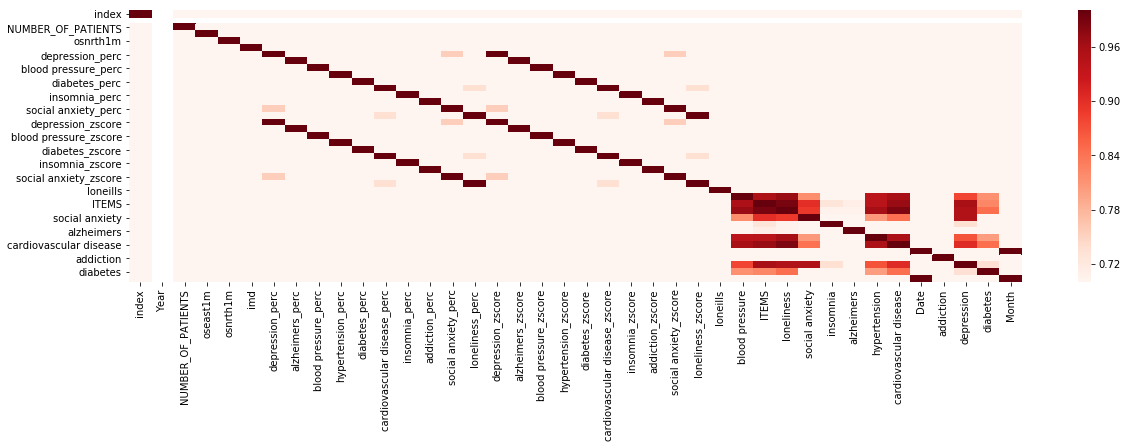

In [11]:
df = agg.loc[ np.abs(agg['loneliness_zscore'] -meanScore) < 5*stdScore ]
plt.figure(figsize=(20,5))
correlations = df.corr()
sns.heatmap(correlations, vmin=0.7, vmax=1 , cmap='Reds')
plt.show()

In [ ]:
geo_data = gpd.GeoDataFrame(proc_data, 
                            crs = {'init':'epsg:27700'}, 
                            geometry = proc_data.apply(lambda geom: Point(geom['oseast1m'],geom['osnrth1m']),axis=1))
geo_data.head(100)

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (16,6), sharex = True, sharey = True)

geo_data[geo_data['Year'] == 2016].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax1);
geo_data[geo_data['Year'] == 2017].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax2);
geo_data[geo_data['Year'] == 2018].plot(column = 'loneills', scheme = 'quantiles', cmap = 'Reds', marker = '.', ax = ax3);
